In [1]:
!pip install diffusers
!pip install accelerate
!pip install git+https://github.com/TencentARC/PhotoMaker.git
!git clone https://github.com/TencentARC/PhotoMaker.git

  Cloning https://github.com/TencentARC/PhotoMaker.git to /tmp/pip-req-build-11chrbkg
  Running command git clone --filter=blob:none --quiet https://github.com/TencentARC/PhotoMaker.git /tmp/pip-req-build-11chrbkg
  Resolved https://github.com/TencentARC/PhotoMaker.git to commit 541fd6dca895b74d90c9ff98bec4f3abcb5b89e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'PhotoMaker' already exists and is not an empty directory.


In [2]:
cd PhotoMaker/

/content/PhotoMaker


In [3]:
import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler, DDIMScheduler
from huggingface_hub import hf_hub_download

from photomaker import PhotoMakerStableDiffusionXLPipeline

In [4]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize

    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = 'SG161222/RealVisXL_V3.0'
device = "cuda"
save_path = "./outputs"

In [5]:
from huggingface_hub import hf_hub_download

photomaker_ckpt = hf_hub_download(repo_id="TencentARC/PhotoMaker", filename="photomaker-v1.bin", repo_type="model")

pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    variant="fp16",
).to(device)

pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_ckpt),
    subfolder="",
    weight_name=os.path.basename(photomaker_ckpt),
    trigger_word="img"
)
pipe.id_encoder.to(device)


#pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
#pipe.fuse_lora()

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe.set_adapters(["photomaker"], adapter_weights=[1.0])
pipe.fuse_lora()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading PhotoMaker components [1] id_encoder from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/3602d02ba7cc99ce8886e24063ed10e4f2510c84]...
Loading PhotoMaker components [2] lora_weights from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/3602d02ba7cc99ce8886e24063ed10e4f2510c84]


/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:1077: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


Input ID images:


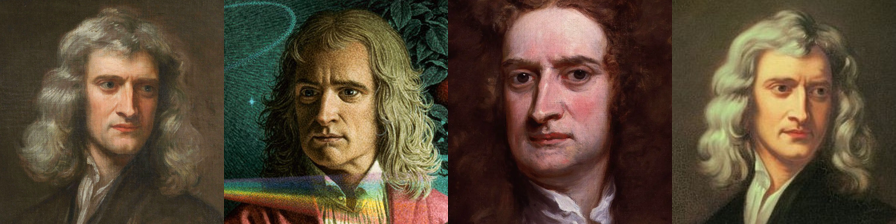

In [6]:
# define and show the input ID images
input_folder_name = './examples/newton_man'
image_basename_list = os.listdir(input_folder_name)
image_path_list = sorted([os.path.join(input_folder_name, basename) for basename in image_basename_list])

input_id_images = []
for image_path in image_path_list:
    input_id_images.append(load_image(image_path))

input_grid = image_grid(input_id_images, 1, 4, size_after_resize=224)
print("Input ID images:")
input_grid

In [7]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "sci-fi, closeup portrait photo of a man img wearing the sunglasses in Iron man suit, face, slim body, high quality, film grain"
negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30

images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=4,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Results:


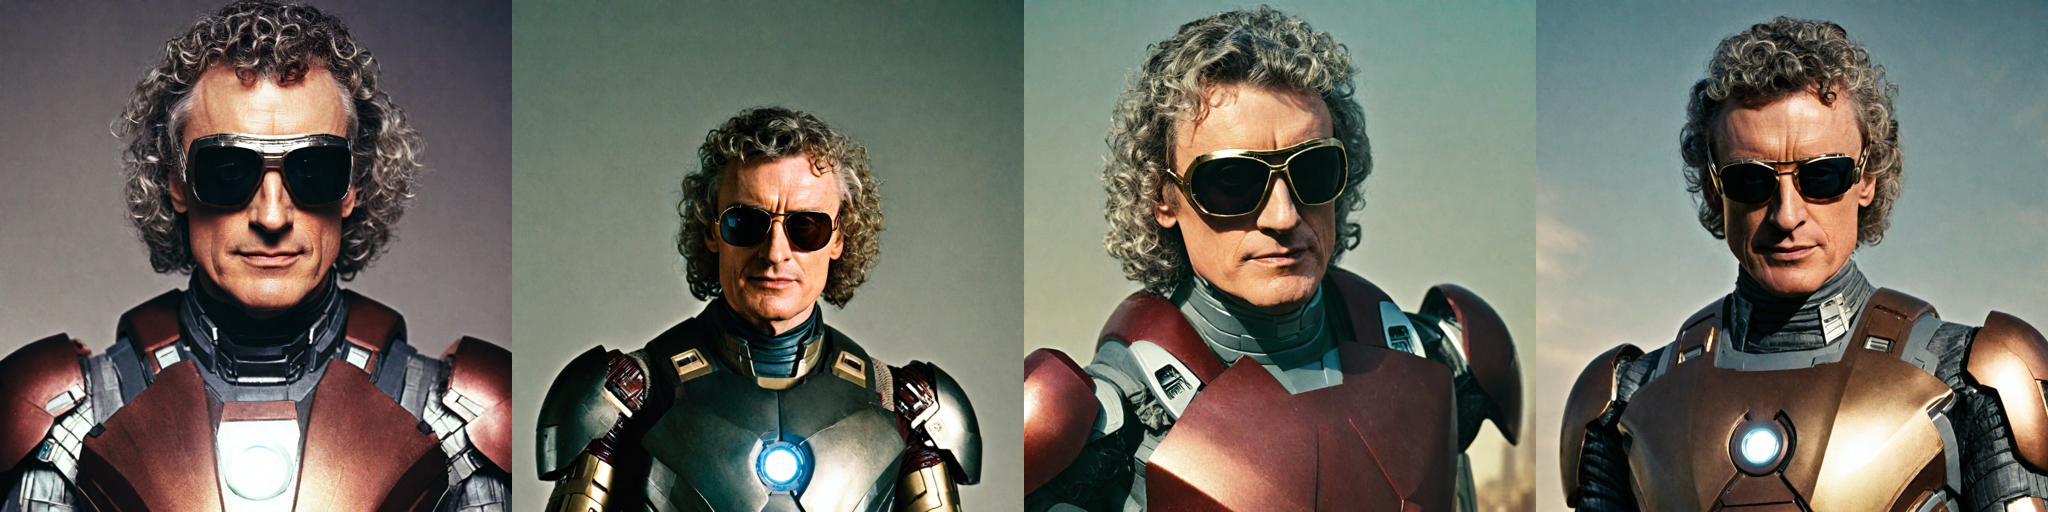

In [8]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 4, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_{idx:02d}.png"))

print("Results:")
grid